In [27]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix as confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")

# Model Implemenation

## Dataset Details:
This dataset captures transaction patterns and behaviors that could indicate potential fraud in card transactions. The data is composed of several features designed to reflect the transactional context such as geographical location, transaction medium, and spending behavior relative to the user's history.

### Attribute Description:
1. **distance_from_home:**  This is a numerical feature representing the geographical distance in kilometers between the transaction location and the cardholder's home address.
2. **distance_from_last_transaction:** This numerical attribute measures the distance in kilometers from the location of the last transaction to the current transaction location.
3. **ratio_to_median_purchase_price:** A numeric ratio that compares the transaction's price to the median purchase price of the user's transaction history.
4. **repeat_retailer:** A binary attribute where '1' signifies that the transaction was conducted at a retailer previously used by the cardholder, and '0' indicates a new retailer.
5. **used_chip:** This binary feature indicates whether the transaction was made using a chip (1) or not (0).
6. **used_pin_number:** Another binary feature, where '1' signifies the use of a PIN number for the transaction, and '0' shows no PIN number was used.
7. **online_order:** This attribute identifies whether the purchase was made online ('1') or offline ('0').
8. **fraud:** A binary target variable indicating whether the transaction was fraudulent ('1') or not ('0').

## Prep the data

In [9]:
# A Parquet file is a column-oriented, open-source data storage format that's used to store flat columnar data.
# It's known for its efficient compression and encoding, and is designed to handle large volumes of complex data.

# Reading credit card transaction data from a Parquet file  https://www.openml.org/search?type=data&status=active&id=45955
fraud_tx_data_df = pd.read_parquet("https://data.openml.org/datasets/0004/45955/dataset_45955.pq")

# Drop the null/na data
fraud_tx_data_df.dropna(inplace=True)

## Save / Backup the data to a csv file in case the data / api is removed from the openml site.
# fraud_tx_data_df.to_csv("credit-card-transaction-data.csv")
fraud_tx_data_df.head()


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


### Based on the dataset this is a Binary Data set. The feature "fraud" provides if its a fraud data.

> Add blockquote



In [10]:
# Get information on the data set
fraud_tx_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  uint8  
 4   used_chip                       1000000 non-null  uint8  
 5   used_pin_number                 1000000 non-null  uint8  
 6   online_order                    1000000 non-null  uint8  
 7   fraud                           1000000 non-null  uint8  
dtypes: float64(3), uint8(5)
memory usage: 27.7 MB


In [11]:
fraud_tx_data_df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


### The data is imbalance based on the distribution of the above count.

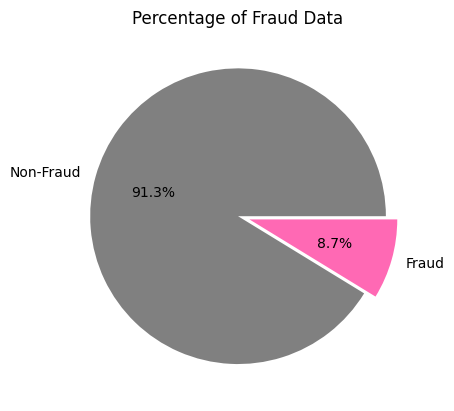

In [12]:
# Calculate the percentage of fraud in the dataset
labeled_data = ["Non-Fraud", "Fraud"]
plt.pie(fraud_tx_data_df["fraud"].value_counts(), labels=labeled_data, autopct="%1.1f%%", colors=["gray", "hotpink"], explode=(0, 0.08))
plt.title("Percentage of Fraud Data")
plt.show()

In [13]:
# Column fraud is the one to predict.
# 0 - no fraud
# 1 - fraud
fraud_tx_data_df["fraud"].value_counts()

,count
fraud,
0,912597
1,87403


## Create X and y training data

In [14]:
# Assign the fraud feature to the y column
y = fraud_tx_data_df["fraud"]
y[:10]

,fraud
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [15]:
# Make a copy of the all the features and drop the y feature.
X = fraud_tx_data_df.copy()
X.drop("fraud", axis=1, inplace=True)
X[:10]

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,57.877857,0.311140,1.945940,1,1,0,0
1,10.829943,0.175592,1.294219,1,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1
3,2.247564,5.600044,0.362663,1,1,0,1
4,44.190936,0.566486,2.222767,1,1,0,1
5,5.586408,13.261073,0.064768,1,0,0,0
6,3.724019,0.956838,0.278465,1,0,0,1
7,4.848247,0.320735,1.273050,1,0,1,0
8,0.876632,2.503609,1.516999,0,0,0,0
9,8.839047,2.970512,2.361683,1,0,0,1


In [16]:
# Split the data into training and testing sets using random_state=1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

## Standard Scalar - Standardize features on X data

In [17]:
# Create the Standard Scalar Object
scaler = StandardScaler()
scaler

StandardScaler()

In [18]:
# Fit the scaler
scaler.fit_transform(X_train)

# Scale the X train data
X_train_scaled = scaler.transform(X_train)
X_train_scaled[:4]

array([[-0.22139338,  0.02528477, -0.57679666,  0.36643627, -0.73517181,
        -0.33490642,  0.73255692],
       [-0.08641302, -0.09726048,  0.12149586,  0.36643627,  1.36022626,
         2.98590872,  0.73255692],
       [-0.10001875, -0.16563608, -0.23506724,  0.36643627, -0.73517181,
        -0.33490642, -1.36508164],
       [-0.35241603, -0.20197118, -0.21196995,  0.36643627, -0.73517181,
        -0.33490642,  0.73255692]])

In [19]:
# Scale the X train test
X_test_scaled = scaler.transform(X_test)
X_test_scaled[:4]

array([[-0.05245033, -0.04722844, -0.4396794 ,  0.36643627,  1.36022626,
        -0.33490642,  0.73255692],
       [ 0.94522164, -0.15615665, -0.02029087,  0.36643627,  1.36022626,
        -0.33490642, -1.36508164],
       [ 0.21656128,  1.77174885, -0.61811477,  0.36643627,  1.36022626,
        -0.33490642, -1.36508164],
       [ 0.245146  , -0.18439965,  0.23950017,  0.36643627,  1.36022626,
         2.98590872,  0.73255692]])

## Logistic Regresssion - Use the model to the predict accuracy

In [ ]:
# Create Logistic Regression Model and random state = 3 and max iteration to 100
lr = LogisticRegression(random_state=3, max_iter=1000)
lr

LogisticRegression(max_iter=1000, random_state=3)

In [ ]:
# Fit and save the logistic regression model using the training the data
lr_model = lr.fit(X_train_scaled, y_train)

In [ ]:
# Score the model
print(f"Training Data Score: {round(lr_model.score(X_train_scaled, y_train),2)}")
print(f"Testing Data Score: {round(lr_model.score(X_test_scaled, y_test),2)}")

Training Data Score: 0.96
Testing Data Score: 0.96


In [ ]:
# Make and save testing predictions with the trained Logistic Regression model using the test data
testing_predictions = lr.predict(X_test_scaled)

# Review the predictions
testing_predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
# Calculate the accuracy score by evaluating `y_test` vs. `testing_predictions`.
accuracy_score(y_test, testing_predictions)

0.958576

In [ ]:
# Compute the metrics for the linear regression model
score  = lr_model.score(X_test_scaled, y_test, sample_weight=None)
r2 = r2_score(y_test, testing_predictions)
print(f"The score is {score}")
print(f"The r2 is {r2}")

The score is 0.958576
The r2 is 0.484402151820316


## Random Forest Classifier - Use the model to the predict accuracy

In [ ]:
rfc = RandomForestClassifier(random_state=3)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=3)

In [ ]:
# Make and save testing predictions with the trained Random Forest Classifier model using the test data
testing_predictions = rfc.predict(X_test_scaled)

# Review the predictions
testing_predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
# Calculate the accuracy score by evaluating `y_test` vs. `testing_predictions`.
accuracy_score(y_test, testing_predictions)

0.999992

In [ ]:
# Compute the metrics for the linear regression model
score  = rfc.score(X_test_scaled, y_test, sample_weight=None)
r2 = r2_score(y_test, testing_predictions)
print(f"The score is {score}")
print(f"The r2 is {r2}")

The score is 0.999992
The r2 is 0.9999004252900386


## Decision Tree Model - Use the hierachrical model to predict accuracy and visualize the tree

In [ ]:
# Create decision tree and fit the model
dtree_model = tree.DecisionTreeClassifier(random_state=3).fit(X_train_scaled, y_train)
dtree_model

DecisionTreeClassifier(random_state=3)

In [ ]:
# Prediction using the testing data
dt_prediction = dtree_model.predict(X_test_scaled)

In [ ]:
# Calculate the accuracy score
acc_score = accuracy_score(y_test, dt_prediction)

print(f"Accuracy Score for  Decision Tree : {acc_score}")

Accuracy Score for  Decision Tree : 0.999992


In [ ]:
# Compute the metrics for the linear regression model
score  = dtree_model.score(X_test_scaled, y_test)
r2 = r2_score(y_test, dt_prediction)
print(f"The score is {score}")
print(f"The r2 is {r2}")

The score is 0.999992
The r2 is 0.9999004252900386


#### Visualize the Decision Tree

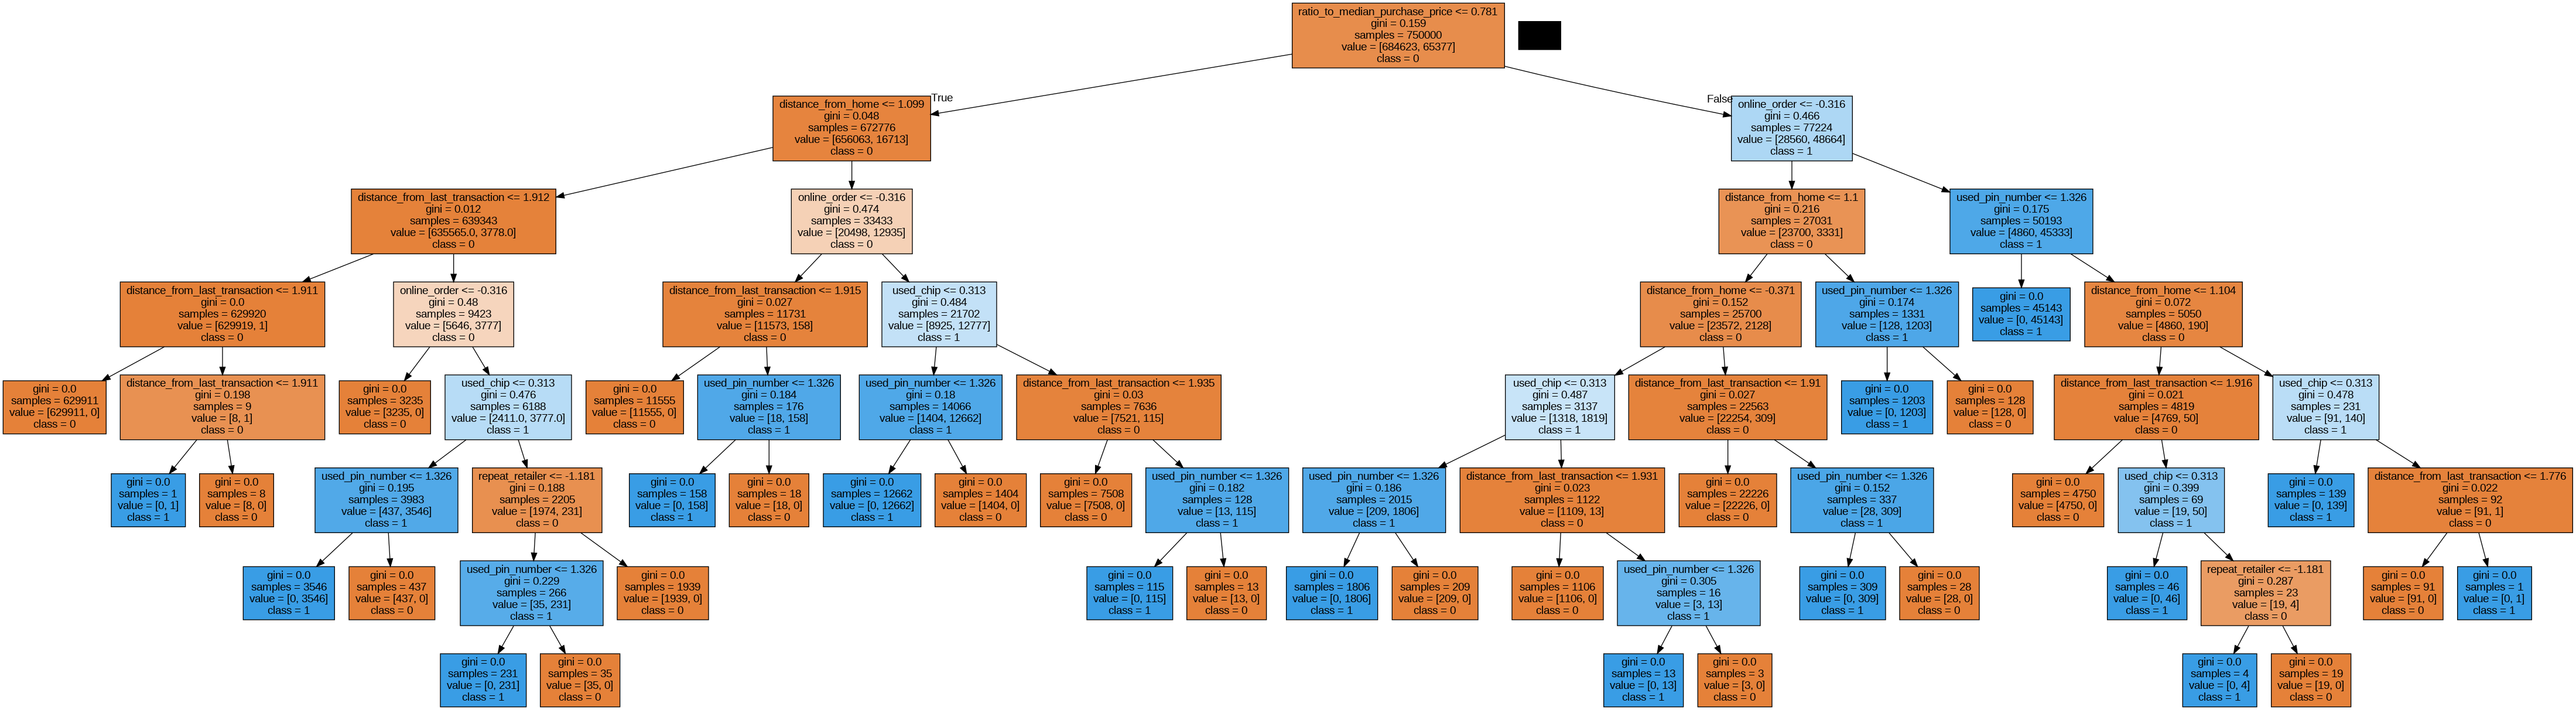

In [ ]:
# Create DOT data
dot_data = tree.export_graphviz(
    dtree_model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [ ]:
file_path = "credit_card_fraud_data_tree.pdf"
graph.write_pdf(file_path)

# Save the tree as PNG
file_path = "credit_card_fraud_data_tree.pdf.png"
graph.write_png(file_path)

True

## K - Nearest Neighbour (KNN) - Use the model to to predict accuracy and find the k-value

In [ ]:
# Create model and fit
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_scaled, y_train)


KNeighborsClassifier(n_neighbors=20)

In [ ]:
# Predict
knn_testing_prediction = knn.predict(X_test_scaled)
knn_testing_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [ ]:
print(f"Accuracy score of KNN model at K=20 is ",accuracy_score(y_test, knn_testing_prediction))

Accuracy score of KNN model at K=20 is  0.998412


In [ ]:
score = knn.score(X_test_scaled, y_test)
r2 = r2_score(y_test, knn_testing_prediction)

print(f"The score is {score}")
print(f"The r2 is {r2}")

The score is 0.998412
The r2 is 0.9802344200726791


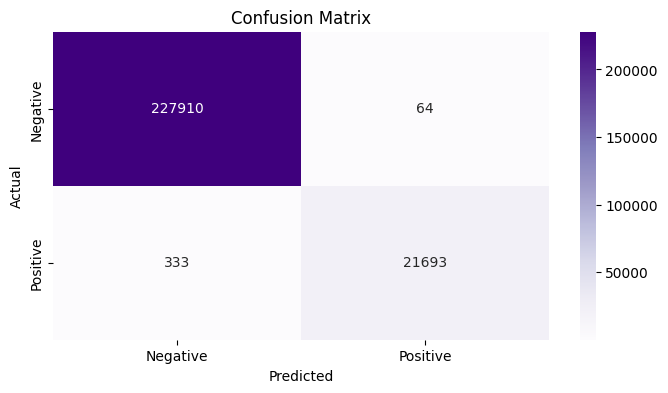

In [ ]:
# Create confusion matrix
confustion_matrix_plot = confusion_matrix(y_test, knn_testing_prediction)
plt.figure(figsize=(8,4))
sb.heatmap(confustion_matrix_plot, annot=True, fmt="d", cmap="Purples", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

k: 1, Train/Test Score & Accuracy: 1.00000/0.99882, 0.99882
k: 3, Train/Test Score & Accuracy: 0.99951/0.99882, 0.99882
k: 5, Train/Test Score & Accuracy: 0.99931/0.99882, 0.99882
k: 7, Train/Test Score & Accuracy: 0.99918/0.99878, 0.99878
k: 9, Train/Test Score & Accuracy: 0.99912/0.99872, 0.99872
k: 11, Train/Test Score & Accuracy: 0.99906/0.99872, 0.99872
k: 13, Train/Test Score & Accuracy: 0.99901/0.99871, 0.99871
k: 15, Train/Test Score & Accuracy: 0.99895/0.99864, 0.99864
k: 17, Train/Test Score & Accuracy: 0.99888/0.99854, 0.99854
k: 19, Train/Test Score & Accuracy: 0.99879/0.99850, 0.99850


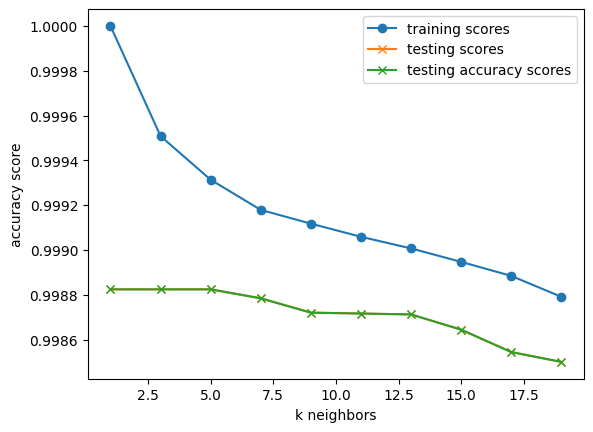

In [ ]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
acc_score = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    test_predict = knn.predict(X_test_scaled)
    test_accuracy_score = accuracy_score(y_test, test_predict)
    train_scores.append(train_score)
    test_scores.append(test_score)
    acc_score.append(test_accuracy_score)
    print(f"k: {k}, Train/Test Score & Accuracy: {train_score:.5f}/{test_score:.5f}, {test_accuracy_score:.5f}")

# Plot the results
plt.plot(range(1, 20, 2), train_scores, marker='o', label="training scores")
plt.plot(range(1, 20, 2), test_scores, marker="x", label="testing scores")
plt.plot(range(1, 20, 2), acc_score, marker="^", label="testing accuracy scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

## Implementation Summary

### Accuracy and R2 Comparsion across 4 models

|                | Logistic Regresssion | Random Forest Classifier | Decision Tree      | K Neighbors Classifier (K=20) |
|----------------|----------------------|--------------------------|--------------------|-------------------------------|
| Accuracy Score |       0.958576       |         0.999992         |      0.999992      |            0.998412           |
| Score          |       0.958576       |         0.999992         |      0.999992      |            0.998412           |
| R2             |   0.484402151820316  |    0.9999004252900386    | 0.9999004252900386 |       0.9802344200726791      |



# Optimization

In [ ]:
# Create three KNN classifiers
untuned_model = KNeighborsClassifier()
grid_tuned_model = KNeighborsClassifier()
random_tuned_model = KNeighborsClassifier()

In [ ]:
target_names = ["negative", "positive"]


In [ ]:
untuned_model.fit(X_train_scaled, y_train)
untuned_y_pred = untuned_model.predict(X_test_scaled)

In [ ]:
# Print classification report
print(classification_report(y_test, untuned_y_pred,
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00    227974
    positive       1.00      0.99      0.99     22026

    accuracy                           1.00    250000
   macro avg       1.00      1.00      1.00    250000
weighted avg       1.00      1.00      1.00    250000



In [ ]:
# Create the grid search estimator along with a parameter object containing the values to adjust.
# Try adjusting n_neighbors with values of 1 through 11. Adjust leaf_size by using 10, 50, and 100.
# Include both uniform and distance options for weights.
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 50, 100]
}
grid_clf = GridSearchCV(grid_tuned_model, param_grid, verbose=3)

In [ ]:
# Fit the model by using the grid search estimator.
# This will take the KNN model and try each combination of parameters.
grid_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.999 total time=  22.3s
[CV 2/5] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.999 total time=  23.5s
[CV 3/5] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.999 total time=  24.8s
[CV 4/5] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.998 total time=  22.8s
[CV 5/5] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.999 total time=  23.7s
[CV 1/5] END leaf_size=10, n_neighbors=1, weights=distance;, score=0.999 total time=  14.6s
[CV 2/5] END leaf_size=10, n_neighbors=1, weights=distance;, score=0.999 total time=  14.5s
[CV 3/5] END leaf_size=10, n_neighbors=1, weights=distance;, score=0.999 total time=  14.4s
[CV 4/5] END leaf_size=10, n_neighbors=1, weights=distance;, score=0.998 total time=  14.5s
[CV 5/5] END leaf_size=10, n_neighbors=1, weights=distance;, score=0.999 total time=  18.0s
[CV 1/5] END leaf_size=

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 50, 100],
                         'n_neighbors': [1, 3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [ ]:
# List the best parameters for this dataset
print(grid_clf.best_params_)

{'leaf_size': 10, 'n_neighbors': 9, 'weights': 'distance'}


In [ ]:
# Print the classification report for the best model
grid_y_pred = grid_clf.predict(X_test_scaled)
print(classification_report(y_test, grid_y_pred,
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00    227974
    positive       1.00      0.99      0.99     22026

    accuracy                           1.00    250000
   macro avg       1.00      1.00      1.00    250000
weighted avg       1.00      1.00      1.00    250000



In [ ]:
# Create the parameter object for the randomized search estimator.
# Try adjusting n_neighbors with values of 1 through 11.
# Adjust leaf_size by using a range from 1 to 100.
# Include both uniform and distance options for weights.
param_grid = {
    'n_neighbors': np.arange(1,12,2),
    'weights': ['uniform', 'distance'],
    'leaf_size': np.arange(1, 100)
}
param_grid

{'n_neighbors': array([ 1,  3,  5,  7,  9, 11]),
 'weights': ['uniform', 'distance'],
 'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}

In [ ]:
# Create the randomized search estimator
random_clf = RandomizedSearchCV(random_tuned_model, param_grid, random_state=0, verbose=3)

In [ ]:
# Fit the model by using the randomized search estimator.
random_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END leaf_size=58, n_neighbors=1, weights=uniform;, score=0.985 total time=  13.6s
[CV 2/5] END leaf_size=58, n_neighbors=1, weights=uniform;, score=0.984 total time=  12.5s
[CV 3/5] END leaf_size=58, n_neighbors=1, weights=uniform;, score=0.984 total time=  12.4s
[CV 4/5] END leaf_size=58, n_neighbors=1, weights=uniform;, score=0.985 total time=  12.6s
[CV 5/5] END leaf_size=58, n_neighbors=1, weights=uniform;, score=0.985 total time=  12.2s
[CV 1/5] END leaf_size=47, n_neighbors=7, weights=distance;, score=0.983 total time=   8.9s
[CV 2/5] END leaf_size=47, n_neighbors=7, weights=distance;, score=0.983 total time=   8.2s
[CV 3/5] END leaf_size=47, n_neighbors=7, weights=distance;, score=0.982 total time=   6.9s
[CV 4/5] END leaf_size=47, n_neighbors=7, weights=distance;, score=0.983 total time=   8.0s
[CV 5/5] END leaf_size=47, n_neighbors=7, weights=distance;, score=0.983 total time=   7.5s
[CV 1/5] END leaf_size=7

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'n_neighbors': array([ 1,  3,  5,  7,  9, 11]),
                                        'weights': ['uniform', 'distance']},
                   random_state=0, verbose=3)

In [ ]:
# List the best parameters for this dataset
print(random_clf.best_params_)

{'weights': 'uniform', 'n_neighbors': 1, 'leaf_size': 58}


In [ ]:
# Make predictions with the hypertuned model
random_tuned_pred = random_clf.predict(X_test_scaled)

In [ ]:
# Calculate the classification report
print(classification_report(y_test, random_tuned_pred,
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.92      1.00      0.96    227974
    positive       0.81      0.07      0.13     22026

    accuracy                           0.92    250000
   macro avg       0.86      0.53      0.54    250000
weighted avg       0.91      0.92      0.88    250000



### Random Undersampling

In [50]:
# Create Random Undersampling
rus = RandomUnderSampler(sampling_strategy='auto',random_state=3)

# Fit the data to he model
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train)

In [51]:
# Count distinct resmapled values
y_rus.value_counts()

,count
fraud,
0,65377
1,65377


In [52]:
# Create Random Forest Classifer with original scaled for X and y
knn_org_model = KNeighborsClassifier(n_neighbors=20)

# Fit the model
knn_org_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=20)

In [53]:
# Create RandomForestClassier instance
knn_resampled_model = KNeighborsClassifier(n_neighbors=20)

# Fit the model
knn_resampled_model.fit(X_rus, y_rus)

KNeighborsClassifier(n_neighbors=20)

In [54]:
# Prediction using original scaled data
org_prediction = knn_org_model.predict(X_test_scaled)

# Prediction using resampled data
resampled_prediction = knn_resampled_model.predict(X_test_scaled)

In [67]:
# Print classification report
target_names = ["negative", "positive"]

print("KNN (k=20) - Classification report before under sampling")
print("--------------------------------------------------------")
print(classification_report(y_test, org_prediction, target_names=target_names))

print("       ")

print("KNN (k=20) - Classification report After under sampling")
print("-------------------------------------------------------")
print(classification_report(y_test, resampled_prediction, target_names=target_names))

KNN (k=20) - Classification report before under sampling
--------------------------------------------------------
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00    227974
    positive       1.00      0.98      0.99     22026

    accuracy                           1.00    250000
   macro avg       1.00      0.99      1.00    250000
weighted avg       1.00      1.00      1.00    250000

       
KNN (k=20) - Classification report After under sampling
-------------------------------------------------------
              precision    recall  f1-score   support

    negative       1.00      0.99      1.00    227974
    positive       0.92      1.00      0.96     22026

    accuracy                           0.99    250000
   macro avg       0.96      1.00      0.98    250000
weighted avg       0.99      0.99      0.99    250000

